1. Load required packages

In [2]:
import warnings
import calmap
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly_calplot import calplot
%matplotlib inline
from yellowbrick.target import ClassBalance
from yellowbrick.target import class_balance

warnings.filterwarnings('ignore')


sns.set_theme(style="darkgrid")
current_palette = sns.color_palette()


In [3]:
pd.options.display.min_rows = 20
pd.options.display.max_columns = 500


### Load in the data

In [4]:
n= 40000000
s= 1000000
skip = sorted(random.sample(range(1,n),n-s))
df_flights = pd.read_csv("../../data/eda/flights/all_flight_data_20182022/all_flight_data_20182022.zip",skiprows=skip, low_memory=False)


In [5]:
df_flights = df_flights.rename(columns={"Operating_Airline ": "Operating_Airline", "Flight_Number_Operating_Airline": "Flight_Number"})

In [6]:
airlines = pd.read_csv(
    "../../data/databases/flight_attributes/airlines.csv.zip", low_memory=False)
airline_mapper = airlines.set_index("Code")["Description"]

In [7]:
cancellation_codes = pd.read_csv(
    "../../data/databases/flight_attributes/cancellation_codes.csv", low_memory=False)
cancellation_code_mapper = cancellation_codes.set_index(
    "CANCELLATION_REASON")["CANCELLATION_DESCRIPTION"]


In [8]:
usa_airports = (pd.read_csv("../../data/databases/flight_attributes/usa_airports.csv.zip",
                            usecols= ["iata","latitude","longitude"], 
                            low_memory=False))
usa_airports = usa_airports.rename(columns={"iata": "Origin"})



### Data Pre-processing Phase
- EDA
- Feature Engineering
  - Handling missing values
  - Encoding Categorical Variables
- Feature Selection 
- Statistical Analysis
- Train - Test Split

In [9]:
#df_flights.dtypes

In [10]:
def airline_mapping(df_flights):
    df_flights["Operating_Airline"] = (
        df_flights["Operating_Airline"].map(airline_mapper))
    df_flights["CancellationCode"] = (
        df_flights["CancellationCode"].map(cancellation_code_mapper))
    return df_flights

def tweak_df_flights(df_flights):
    SELECTED_COLUMNS = ["FlightDate", "Operating_Airline", "Tail_Number", "Flight_Number", "OriginAirportID",
                        "Origin", "OriginCityName", "OriginState", "OriginStateName", "DestAirportID", "Dest", "DestCityName",
                        "DestState", "DestStateName", "CRSDepTime", "DepTime", "DepDelay", "DepDel15", "DepDelayMinutes", "DepTimeBlk",
                        "TaxiOut", "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrDel15", "ArrTimeBlk",
                        "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime", "AirTime", "Distance", "CarrierDelay",
                        "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "FirstDepTime", "TotalAddGTime",
                        ]
    df_flights = (
        df_flights[SELECTED_COLUMNS]
        .copy()
    )
    df_flights = (pd.merge(df_flights, usa_airports, how="left", on=["Origin"]))
    df_flights.pipe(airline_mapping)
    return df_flights.assign(
        DepTime=df_flights.DepTime.fillna(0).astype("float16"),
        DepDelay=df_flights.DepDelay.fillna(0).astype("float16"),
        DepDel15=df_flights.DepDel15.fillna(0).astype("float16"),
        DepDelayMinutes=df_flights.DepDelayMinutes.fillna(0).astype("float16"),
        TaxiOut=df_flights.TaxiOut.fillna(0).astype("float16"),
        WheelsOn=df_flights.WheelsOn.fillna(0).astype("float16"),
        TaxiIn=df_flights.TaxiIn.fillna(0).astype("float16"),
        ArrDel15=df_flights.ArrDel15.fillna(0).astype("float16"),
        ArrDelayMinutes=df_flights.ArrDelayMinutes.fillna(0).astype("float16"),
        CRSElapsedTime=df_flights.CRSElapsedTime.fillna(0).astype("float16"),
        ArrTime=df_flights.ArrTime.fillna(0).astype("float16"),
        AirTime=df_flights.AirTime.fillna(0).astype("float16"),
        Distance=df_flights.Distance.fillna(0).astype("float16"),
        CarrierDelay=df_flights.CarrierDelay.fillna(0).astype("float16"),
        WeatherDelay=df_flights.WeatherDelay.fillna(0).astype("float16"),
        NASDelay=df_flights.NASDelay.fillna(0).astype("float16"),
        SecurityDelay=df_flights.SecurityDelay.fillna(0).astype("float16"),
        LateAircraftDelay=df_flights.LateAircraftDelay.fillna(
            0).astype("float16"),
        FirstDepTime=df_flights.FirstDepTime.fillna(0).astype("float16"),
        TotalAddGTime=df_flights.TotalAddGTime.fillna(0).astype("float16"),
        CancellationCode=df_flights.CancellationCode.fillna(
            "none").astype("category"),
        Tail_Number=df_flights.Tail_Number.fillna("none").astype("category"),
        FlightDate=pd.to_datetime(df_flights.FlightDate)
    ).astype(
        {
            "Operating_Airline": "category",
            "Origin": "category",
            "Dest": "category",
            "DestState": "category",
            "OriginState": "category",
            "OriginCityName": "category",
            "OriginStateName": "category",
            "DestStateName": "category",
            "DestCityName": "category",
            "DepTimeBlk": "category",
            "ArrTimeBlk": "category",
            #"Cancelled": "bool",
            "Diverted": "bool",
            "OriginAirportID": "int16",
            "DestAirportID": "int16",
            "CRSDepTime": "int16",
            "CRSArrTime": "int16",
            "Flight_Number": "int16",
            "latitude": "float16",
            "longitude": "float16"
        }
    )


df_flights = tweak_df_flights(df_flights)

##########Flight Status Categories####################
###############DepDelayGroups#########################
# Departure Delay intervals until 180 mins
def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 15, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 15) & (df_flights["DepDelayMinutes"] <= 45), "DepDelayClass"] = "Delay15_45"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 45), "DepDelayClass"] = "Delay45_180"
    df_flights.loc[(df_flights["Cancelled"] > 0), "DepDelayClass"] = "Cancelled"
    
DepDelay_Class(df_flights)
df_flights["DepDelayClass"].astype("category")

# Handling Ordinal Categorical Variables [Label Encoding]
# assign the feature with ranks [Ordinal numbering encoding (Label Encoding)]
# engineer categorical variable by ordinal number replacement
DepDelayClass_mapping = {
    'OnTime': '1',
    'Delay15_45': '2',
    'Delay45_180': '3',
    'Cancelled': '4',
    }

df_flights["DepDelayClass_ordinal"] = df_flights.DepDelayClass.map(DepDelayClass_mapping)


print(df_flights.shape)
df_flights.tail()


(745540, 45)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,DepDelayClass_ordinal
745535,2022-08-18,Comair Inc.,N580NN,5287,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,12451,JAX,"Jacksonville, FL",FL,Florida,1047,1040.0,-7.0,0.0,0.0,1000-1059,33.0,1300.0,6.0,1308,1306.0,0.0,0.0,1300-1359,0.0,none,False,141.0,107.0,742.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.87500,-75.2500,OnTime,1
745536,2022-08-22,Comair Inc.,N563NN,5290,11057,CLT,"Charlotte, NC",NC,North Carolina,11995,GSO,"Greensboro/High Point, NC",NC,North Carolina,1620,1707.0,47.0,1.0,47.0,1600-1659,20.0,1752.0,7.0,1714,1759.0,45.0,1.0,1700-1759,0.0,none,False,54.0,25.0,83.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,35.21875,-80.9375,Delay45_180,3
745537,2022-08-02,Comair Inc.,N520DC,5292,11057,CLT,"Charlotte, NC",NC,North Carolina,15412,TYS,"Knoxville, TN",TN,Tennessee,2040,2033.0,-7.0,0.0,0.0,2000-2059,35.0,2140.0,6.0,2142,2146.0,4.0,0.0,2100-2159,0.0,none,False,62.0,32.0,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.21875,-80.9375,OnTime,1
745538,2022-08-04,Comair Inc.,N524AE,5292,11057,CLT,"Charlotte, NC",NC,North Carolina,15412,TYS,"Knoxville, TN",TN,Tennessee,2040,2210.0,90.0,1.0,90.0,2000-2059,29.0,2312.0,5.0,2142,2316.0,95.0,1.0,2100-2159,0.0,none,False,62.0,33.0,177.0,0.0,48.0,5.0,0.0,42.0,0.0,0.0,35.21875,-80.9375,Delay45_180,3
745539,2022-08-20,Comair Inc.,N574NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,834,825.0,-9.0,0.0,0.0,0800-0859,11.0,930.0,2.0,1006,932.0,0.0,0.0,1000-1059,0.0,none,False,92.0,54.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.84375,-77.0625,OnTime,1


In [11]:
#df_flights.info()

Feature Selection 

In [12]:
#df_flights.columns.to_list()

In [13]:
####Feature Selection#####
ml_cols = [
    'FlightDate',
    'Operating_Airline',
    'Tail_Number',
    'Flight_Number',
    'OriginAirportID',
    #'Origin',
    #'OriginCityName',
    #'OriginState',
    #'OriginStateName',
    'DestAirportID',
    #'Dest',
    #'DestCityName',
    #'DestState',
    #'DestStateName',
    'CRSDepTime',
    'DepTime',
    #'DepDelay',
    #'DepDel15',
    'DepDelayMinutes',
    #'DepTimeBlk',
    'TaxiOut',
    'WheelsOn',
    'TaxiIn',
    'CRSArrTime',
    #'ArrTime',
    #'ArrDelayMinutes',
    #'ArrDel15',
    #'ArrTimeBlk',
    'Cancelled',
    #'CancellationCode',
    #'Diverted',
    'CRSElapsedTime',
    'AirTime',
    'Distance',
    #'CarrierDelay',
    #'WeatherDelay',
    #'NASDelay',
    #'SecurityDelay',
    #'LateAircraftDelay',
    #'FirstDepTime',
    'TotalAddGTime',
    'latitude',
    'longitude',
    'DepDelayClass',
    ]

df_flights_2= df_flights[ml_cols]
df_flights_2.columns

Index(['FlightDate', 'Operating_Airline', 'Tail_Number', 'Flight_Number',
       'OriginAirportID', 'DestAirportID', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'TaxiOut', 'WheelsOn', 'TaxiIn', 'CRSArrTime',
       'Cancelled', 'CRSElapsedTime', 'AirTime', 'Distance', 'TotalAddGTime',
       'latitude', 'longitude', 'DepDelayClass'],
      dtype='object')

Statistical Analysis
- Flights per airline
- Distribution of flight delays by year
- Distribution of flight delays by airline
- Distribution of flight cancellations by airline
- Most reliable airline (on time)

In [14]:
#Flights per airline
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Number of Flights per airline",
    height=700,
)

Text(0.5, 0, 'Number of Flights ')

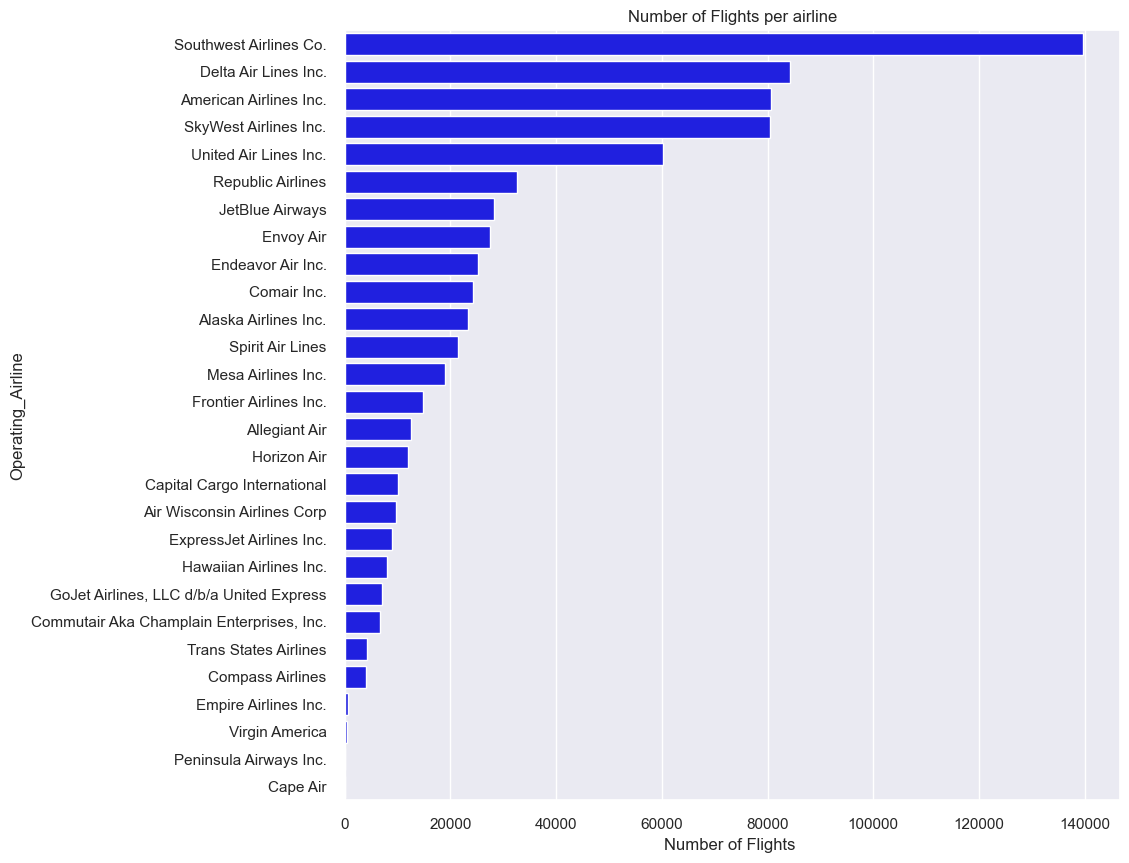

In [15]:
fig,ax = plt.subplots(figsize=(10,10))
sorted_airlines = df_flights["Operating_Airline"].value_counts().index.tolist()
sns.countplot(y=df_flights["Operating_Airline"], order=sorted_airlines, color='blue')
ax.set_title("Number of Flights per airline")
ax.set_xlabel("Number of Flights ")

In [16]:
fig = px.line(df_flights
              .groupby("FlightDate")
              [["DepDelayMinutes"]]
              .mean(),
              title="Distribution of flight delays"
              )
fig.show()


In [17]:
fig = px.bar(df_flights
              .groupby("Operating_Airline")
              [["DepDelayMinutes"]]
              .mean(),
              title="Distribution of flight delays by airline"
              )
fig.show()

In [18]:
fig = px.line(df_flights
              .groupby("FlightDate")
              [["Cancelled"]]
              .mean(),
              title="Distribution of flight cancellations"
              )
fig.show()

In [19]:
fig = px.bar(df_flights
              .groupby("Operating_Airline")
              [["Cancelled"]]
              .mean(),
              title="Distribution of flight cancellations by airline",
              height=700
              )
fig.show()

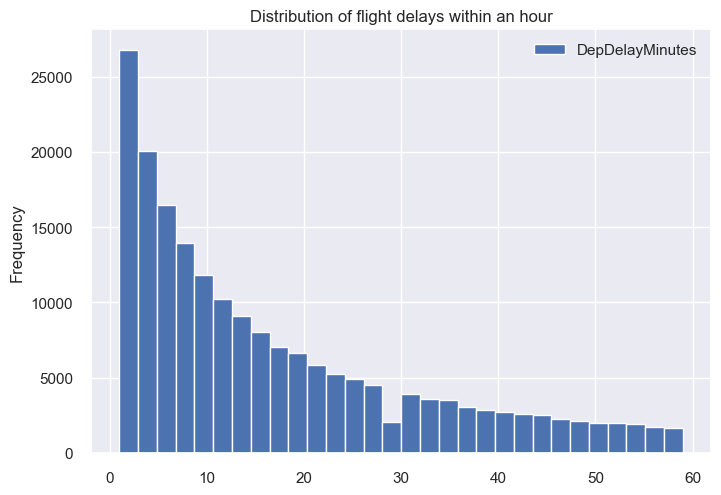

In [20]:
(df_flights
 .query("DepDelayMinutes > 0 and DepDelayMinutes < 60")
 [["DepDelayMinutes"]]
 .plot(kind="hist", bins=30, title="Distribution of flight delays within an hour"))
plt.show()


In [21]:
df_flights_2.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,DestAirportID,CRSDepTime,DepTime,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,Cancelled,CRSElapsedTime,AirTime,Distance,TotalAddGTime,latitude,longitude,DepDelayClass
0,2018-01-18,Endeavor Air Inc.,N8918B,3302,10397,11641,1708,1714.0,6.0,11.0,1819.0,3.0,1828,0.0,80.0,54.0,331.0,0.0,33.62500,-84.4375,OnTime
1,2018-01-26,Endeavor Air Inc.,N800AY,3302,11641,10397,1853,1840.0,0.0,18.0,2001.0,12.0,2030,0.0,97.0,63.0,331.0,0.0,35.00000,-78.8750,OnTime
2,2018-01-15,Endeavor Air Inc.,N8869B,3305,10397,14108,1001,1001.0,0.0,20.0,1056.0,7.0,1103,0.0,122.0,95.0,565.0,0.0,33.62500,-84.4375,OnTime
3,2018-01-22,Endeavor Air Inc.,N8869B,3306,11150,10397,615,613.0,0.0,9.0,641.0,9.0,711,0.0,56.0,19.0,83.0,0.0,32.53125,-84.9375,OnTime
4,2018-01-28,Endeavor Air Inc.,N834AY,3309,11433,14108,1005,1000.0,0.0,14.0,1015.0,3.0,1044,0.0,99.0,61.0,346.0,0.0,42.21875,-83.3750,OnTime


Class Balance

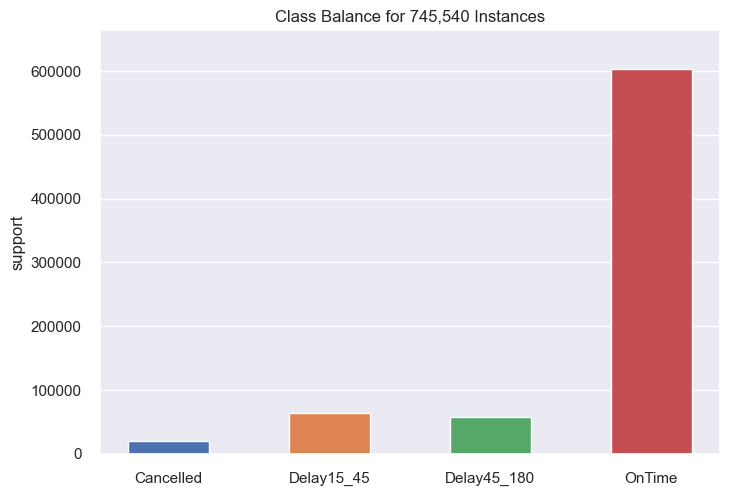

ClassBalance(ax=<AxesSubplot: title={'center': 'Class Balance for 745,540 Instances'}, ylabel='support'>)

In [22]:
y = df_flights["DepDelayClass"]
class_balance(y)

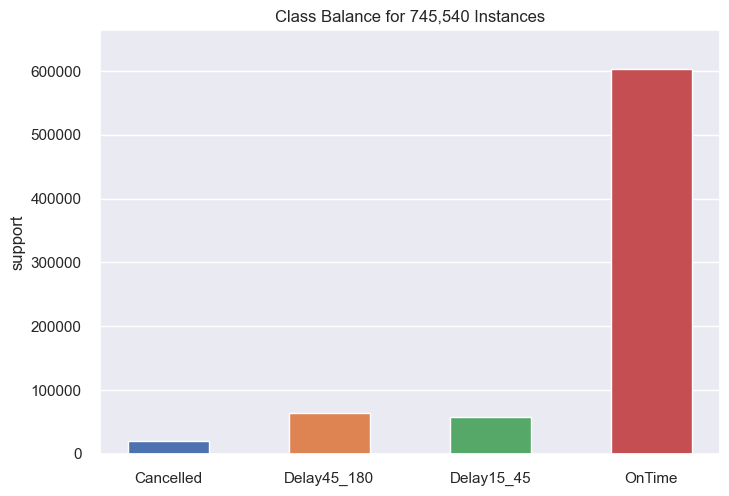

<AxesSubplot: title={'center': 'Class Balance for 745,540 Instances'}, ylabel='support'>

In [23]:
visualizer = ClassBalance(labels=["Cancelled", "Delay45_180", "Delay15_45", "OnTime"])
y = df_flights["DepDelayClass"]
visualizer.fit(y)
visualizer.show()

 In the above figure we can see that the "OnTime" class dominates the other three classes. One potential solution might be to create a binary classifier: "OnTime" vs "not OnTime" and combining the "Delay15_45", "Delay45_180"  and "Cancelled" classes into one class.

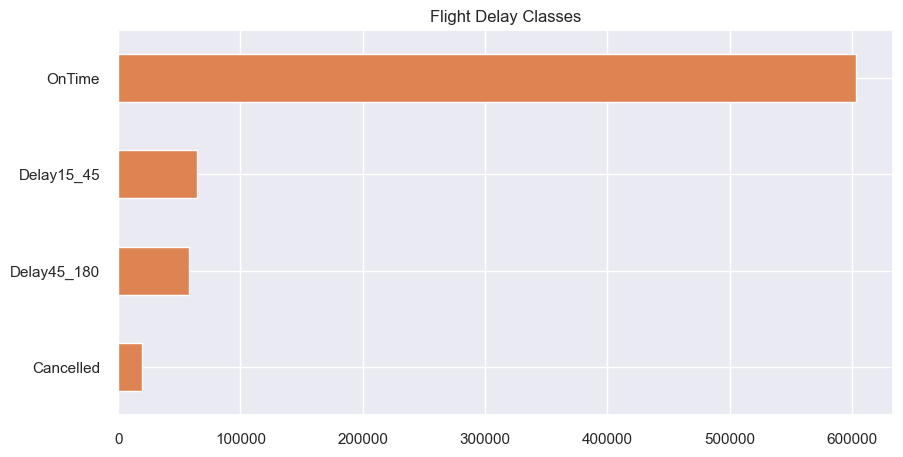

In [24]:
(df_flights
 .DepDelayClass
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Delay Classes")
 )
plt.show()

Percentage of flights per year 

In [25]:
df_flights["Year"] = df_flights["FlightDate"].dt.year
df_flights_agg = df_flights.groupby("Year")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2018,1.559966,9.601303,8.435892,80.402839
2019,1.880228,9.061670,8.698410,80.359692
2020,5.998044,4.547225,3.811878,85.642852
2021,1.739103,8.968179,7.459353,81.833365
2022,2.978136,10.947078,9.717682,76.357104


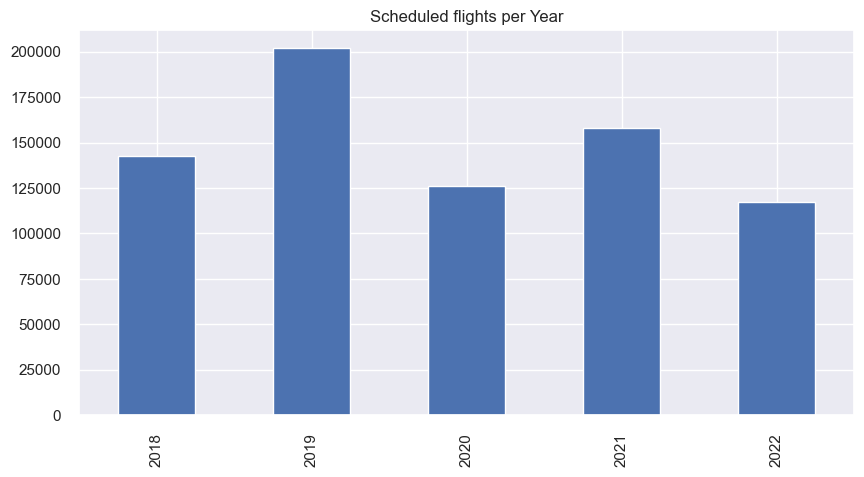

In [26]:
df_flights["Year"].value_counts().sort_index().plot(kind="bar", figsize=(10,5), title="Scheduled flights per Year")
plt.show()

In [27]:
px.bar(
    df_flights["Year"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='v',
    template="plotly_dark",
    title="Scheduled flights per year",
    height=700,
)

Percentage of Flights by Month

In [28]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.groupby("Month")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
1,3.037622,7.888927,7.106554,81.966897
2,3.033962,8.698832,7.841703,80.425503
3,5.613625,7.837999,6.122013,80.426362
4,6.800798,7.672494,6.981420,78.545289
5,1.882838,9.029103,7.953926,81.134133
6,1.962854,10.772606,10.396530,76.868010
7,1.699742,9.904832,10.061232,78.334194
8,2.213518,9.565609,9.297902,78.922971
9,1.372045,6.804113,5.806755,86.017087


- Why the high cancellations in March - April?
- Lets analyse per year for these months 

In [29]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.query("3 <= Month <= 4").groupby("Year")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2018,1.673983,9.522891,7.660765,81.142361
2019,2.128096,8.761197,7.938645,81.172063
2020,24.770322,3.333721,2.721247,69.174710
2021,0.871752,5.481978,4.103101,89.543168
2022,2.044781,11.089527,9.416215,77.449477


The analysis shows that the majority of cancellations happened in 2020 March -April 2020, which was when we had covid-19

- How about the situation without 2020?

In [30]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.query("Year != 2020").groupby("Month")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
1,3.618207,8.028205,7.403833,80.949755
2,3.744937,9.283648,8.265247,78.706168
3,1.888547,9.047944,7.060699,82.002809
4,1.600852,8.594427,7.800318,82.004404
5,1.490462,9.636097,8.516397,80.357044
6,2.122603,11.539938,11.251074,75.086385
7,1.839049,10.927931,11.156096,76.076924
8,2.439224,10.489316,10.342178,76.729282
9,1.474767,7.485791,6.467447,84.571994


  Observations
  - Without the year 2020 when covid-19 was at its peak, we see that most cancellations happened in the months of January and February, this would be due to the weather
    - Winter: December, January, February
    - Spring: March, April, May
    - Summer: June, July, August
    - Autumn: September, October, November

Lets group by Month and Year analyse the cancellations

In [31]:
df_flights_agg = df_flights.query("Cancelled > 0").groupby(["Month", "Year"]).size().unstack()
df_flights_agg.style.background_gradient(cmap="YlGnBu")

Year,2018,2019,2020,2021,2022
Month,,,,,
1,343.000000,450.000000,213.000000,116.000000,928.000000
2,126.000000,443.000000,166.000000,479.000000,570.000000
3,215.000000,371.000000,2947.000000,151.000000,258.000000
4,132.000000,356.000000,3443.000000,57.000000,342.000000
5,113.000000,340.000000,301.000000,60.000000,291.000000
6,103.000000,386.000000,29.000000,211.000000,461.000000
7,161.000000,371.000000,80.000000,267.000000,273.000000
8,300.000000,353.000000,79.000000,464.000000,375.000000
9,210.000000,288.000000,73.000000,187.000000,nan


(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot: ylabel='2018'>, <AxesSubplot: ylabel='2019'>,
        <AxesSubplot: ylabel='2020'>, <AxesSubplot: ylabel='2021'>,
        <AxesSubplot: ylabel='2022'>], dtype=object))

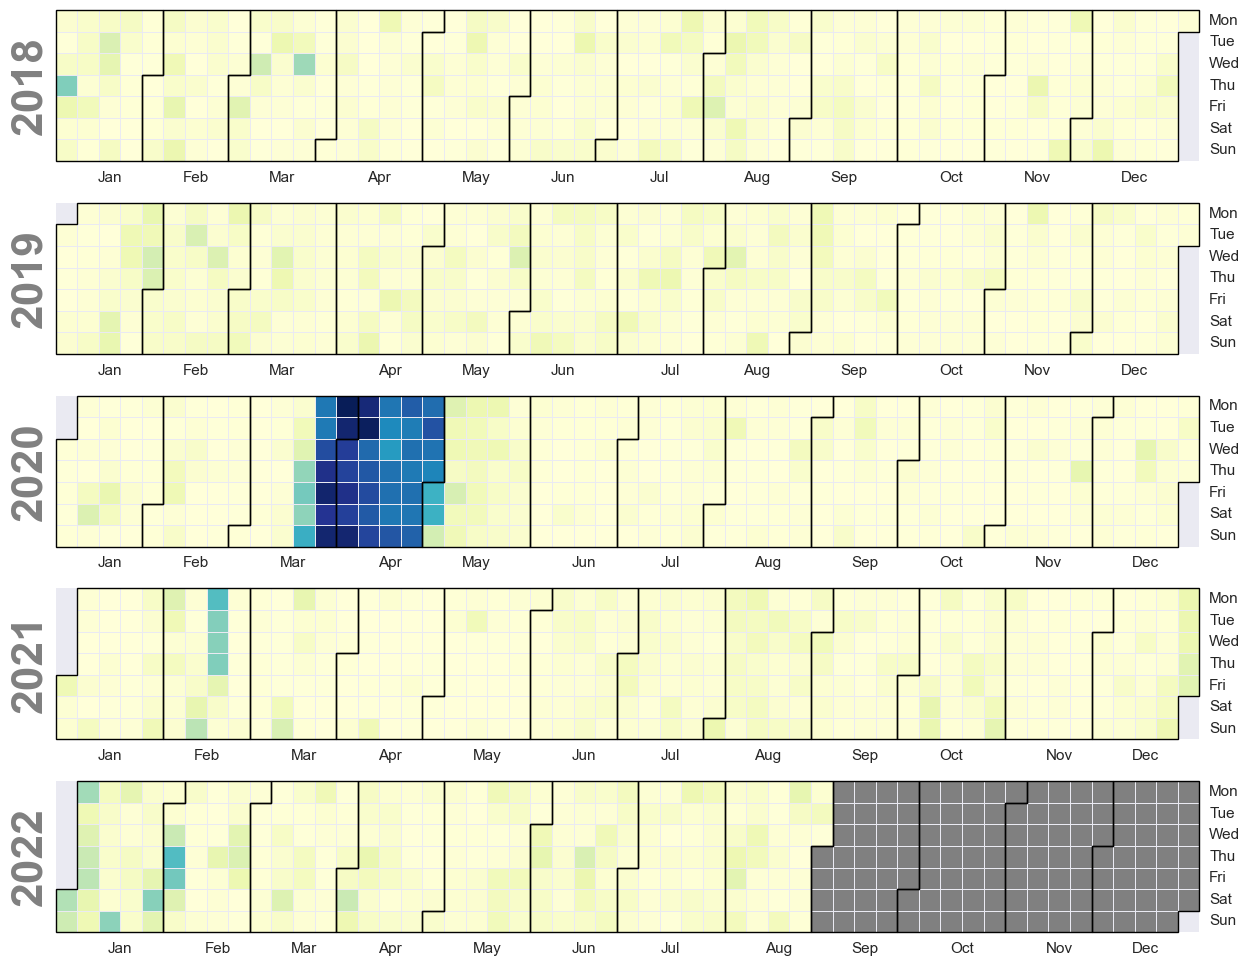

In [32]:
events = df_flights.groupby("FlightDate")["Cancelled"].mean()
calmap.calendarplot(events, monthticks=3, daylabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                    dayticks=True, cmap='YlGnBu',
                    fillcolor='grey', linewidth=0.5, monthly_border=True, 
                    fig_kws=dict(figsize=(20, 10)))

In [33]:
fig = calplot(
         events.reset_index(),
         x="FlightDate",
         y="Cancelled",
         colorscale="Reds",
         years_title=True
)
fig.show()

In [34]:
df_flights.groupby(["Operating_Airline"])[["DepDelayClass"]].value_counts(normalize=True).unstack()

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Operating_Airline,,,,
Air Wisconsin Airlines Corp,0.035637,0.061874,0.091829,0.810660
Alaska Airlines Inc.,0.020241,0.081306,0.050021,0.848431
Allegiant Air,0.041687,0.110442,0.097831,0.750040
American Airlines Inc.,0.030636,0.088808,0.081565,0.798990
Cape Air,0.000000,0.018519,0.000000,0.981481
Capital Cargo International,0.039319,0.056551,0.072299,0.831831
Comair Inc.,0.033128,0.073237,0.081912,0.811723
"Commutair Aka Champlain Enterprises, Inc.",0.043878,0.075090,0.130730,0.750302
Compass Airlines,0.013032,0.077699,0.084091,0.825178


<AxesSubplot: ylabel='Operating_Airline'>

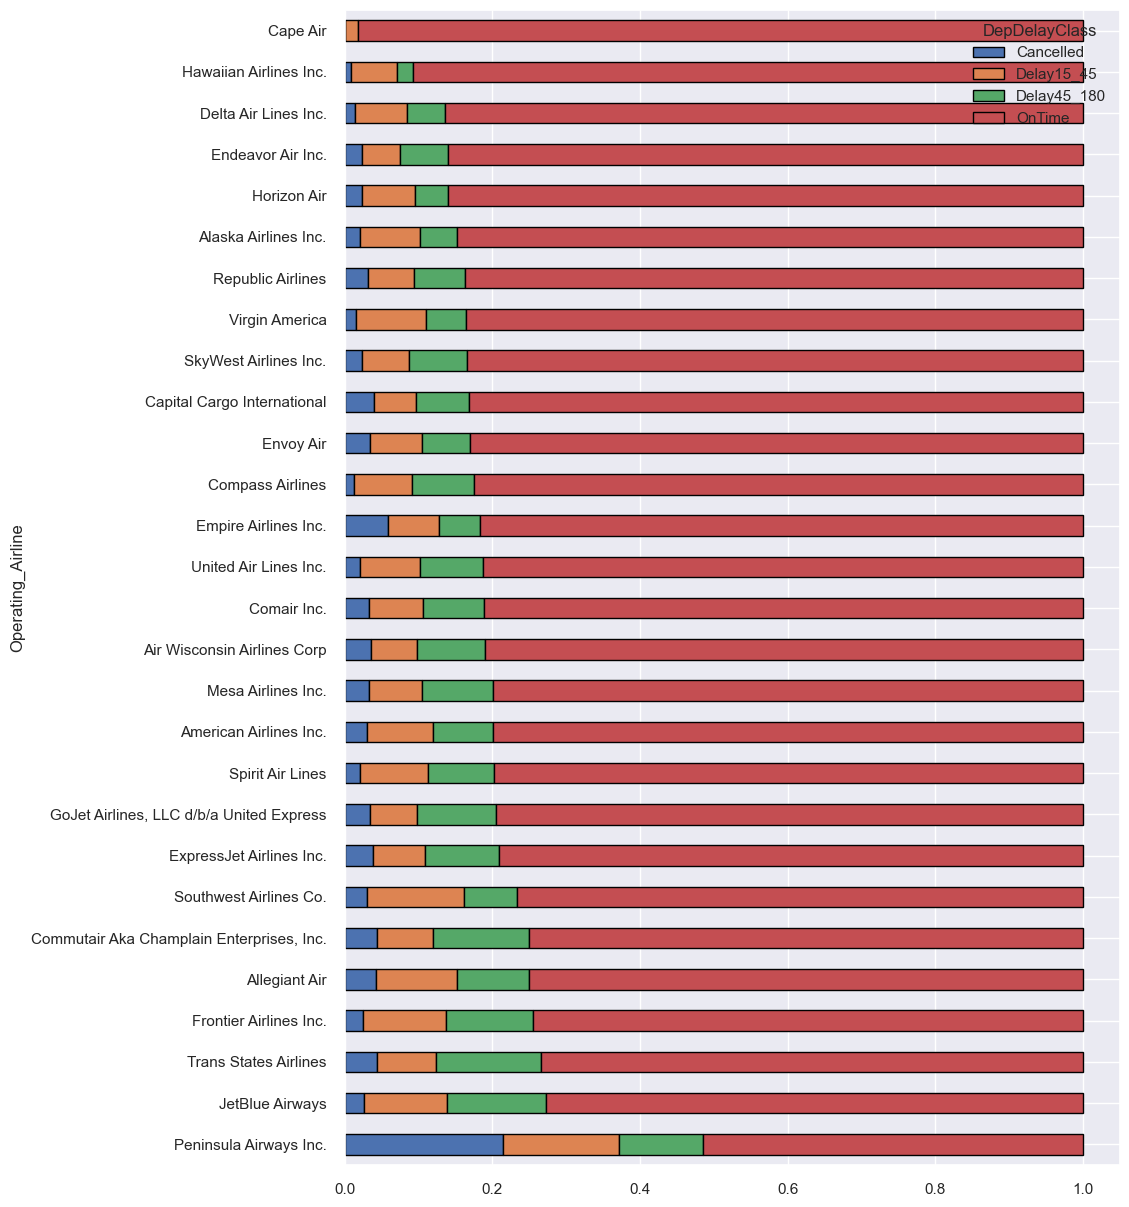

In [35]:
stacked_df_flights = df_flights.groupby(["Operating_Airline"])[["DepDelayClass"]].value_counts(normalize=True).unstack()
stacked_df_flights.sort_values("OnTime").plot(kind='barh', figsize=(10,15), stacked=True, edgecolor="black")

In [36]:
fig = px.bar(stacked_df_flights.sort_values("OnTime"), barmode='stack', height=700, orientation='h')
fig.show()


#### Correlation [Pearson]

In [37]:
corr = (df_flights_2
        .select_dtypes('float16')
        .corr())
corr.style.background_gradient(cmap='coolwarm')


,DepTime,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,CRSElapsedTime,AirTime,Distance,TotalAddGTime,latitude,longitude
DepTime,1.000000,0.126576,0.115842,0.731674,0.045470,-0.018118,0.074859,-0.010393,0.022165,-0.035831,-0.003134
DepDelayMinutes,0.126576,1.000000,0.063560,0.038478,0.025805,0.012330,0.015911,0.008573,0.220724,-0.003835,0.031142
TaxiOut,0.115842,0.063560,1.000000,0.136774,0.075639,0.067537,0.103060,0.028592,0.020904,0.081969,0.103173
WheelsOn,0.731674,0.038478,0.136774,1.000000,0.077099,0.024436,0.122338,0.025681,-0.019493,-0.020485,-0.003041
TaxiIn,0.045470,0.025805,0.075639,0.077099,1.000000,0.096957,0.118254,0.066588,0.000332,-0.002131,0.048483
CRSElapsedTime,-0.018118,0.012330,0.067537,0.024436,0.096957,1.000000,0.946640,0.982310,0.008054,-0.039652,-0.031245
AirTime,0.074859,0.015911,0.103060,0.122338,0.118254,0.946640,1.000000,0.943117,-0.005081,-0.055738,-0.061432
Distance,-0.010393,0.008573,0.028592,0.025681,0.066588,0.982310,0.943117,1.000000,0.004161,-0.073532,-0.123981
TotalAddGTime,0.022165,0.220724,0.020904,-0.019493,0.000332,0.008054,-0.005081,0.004161,1.000000,0.006815,0.018528
latitude,-0.035831,-0.003835,0.081969,-0.020485,-0.002131,-0.039652,-0.055738,-0.073532,0.006815,1.000000,0.003926


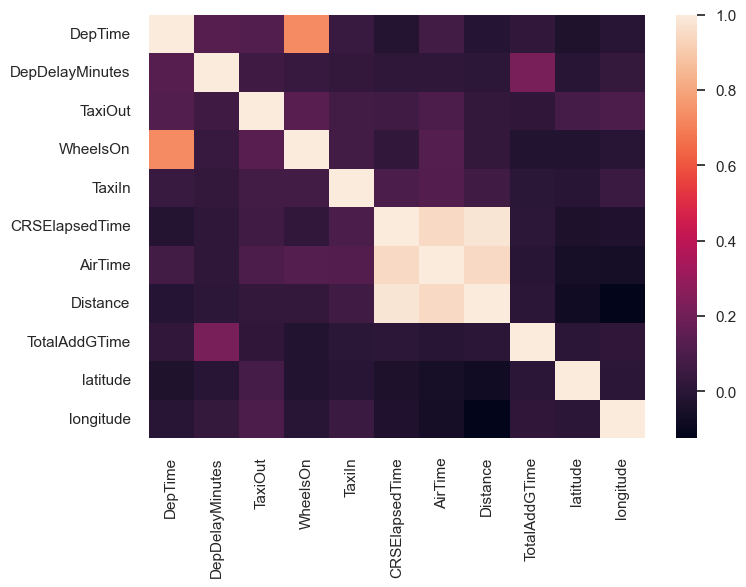

In [38]:
sns.heatmap(
    (df_flights_2
     .select_dtypes('float16')
     .corr()))
plt.show()


In [39]:
# Factors affecting delay
# Assumption: A flight is counted as "on time" if it operated less than 15 minutes later than the
def flight_status(df_flights):
        df_flights["FlightStatus"]="OnTime"

        df_flights.loc[df_flights["DepDel15"] == 0, "FlightStatus"]="OnTime"
        df_flights.loc[(df_flights["DepDelayMinutes"] >= 0) & (df_flights["DepDelayMinutes"] <= 15), "FlightStatus"]="OnTime"
        df_flights.loc[df_flights["WeatherDelay"] > 15, "FlightStatus"]="WeatherDelay"
        df_flights.loc[df_flights["NASDelay"] > 15, "FlightStatus"]="NASDelay"
        df_flights.loc[df_flights["SecurityDelay"] > 15, "FlightStatus"]="SecurityDelay"
        df_flights.loc[df_flights["LateAircraftDelay"] > 15, "FlightStatus"]="LateAircraftDelay"
        df_flights.loc[df_flights["CarrierDelay"] > 15, "FlightStatus"]="CarrierDelay"
        df_flights.loc[df_flights["Cancelled"], "FlightStatus"]="Cancelled"
    

flight_status(df_flights)

<AxesSubplot: xlabel='FlightDate'>

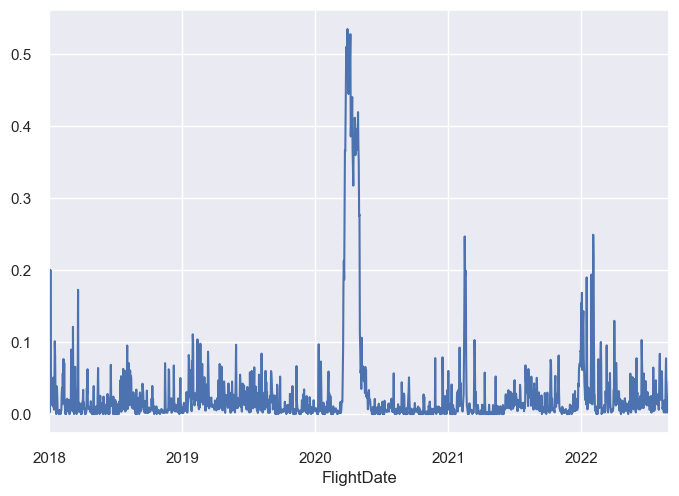

In [40]:
(df_flights.
 groupby("FlightDate")
 ["Cancelled"]
 .agg("mean")
 .plot()
 )


<AxesSubplot: xlabel='FlightDate'>

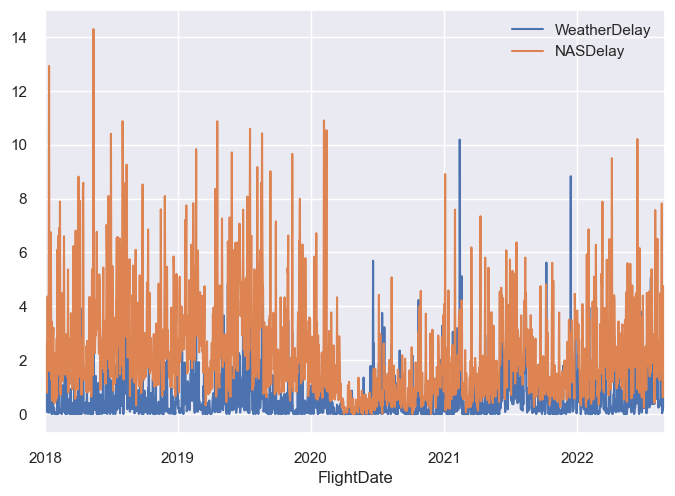

In [41]:
(df_flights.
 groupby("FlightDate")
 [["WeatherDelay", "NASDelay"]]
 .agg("mean")
 .plot())


<AxesSubplot: xlabel='FlightDate'>

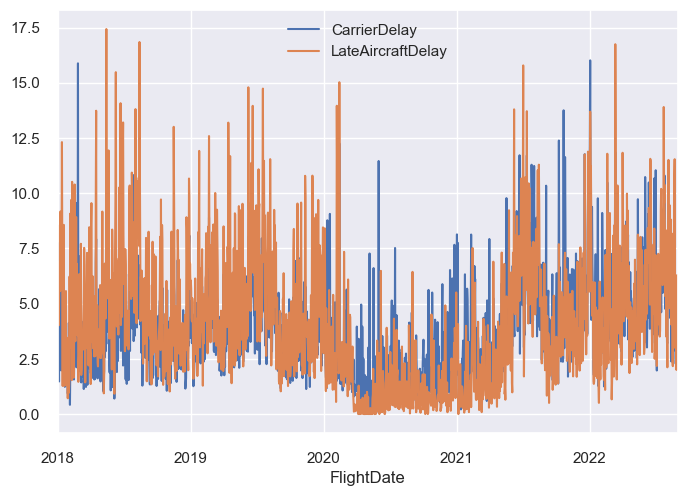

In [42]:
(df_flights.
 groupby("FlightDate")
 [["CarrierDelay", "LateAircraftDelay"]]
 .agg("mean")
 .plot())


##### Frequency Distribution Table

In [43]:
(df_flights
 [["Operating_Airline"]]
 .value_counts()
 .sort_values(ascending=False)
 .to_frame("Row Count")
 )


,Row Count
Operating_Airline,
Southwest Airlines Co.,139663
Delta Air Lines Inc.,84332
American Airlines Inc.,80623
SkyWest Airlines Inc.,80399
United Air Lines Inc.,60215
Republic Airlines,32624
JetBlue Airways,28292
Envoy Air,27502
Endeavor Air Inc.,25158


In [44]:
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Flights per airline",
    height=700,
)


In [45]:
df_flights.head(3)

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,DepDelayClass_ordinal,Year,Month,FlightStatus
0,2018-01-18,Endeavor Air Inc.,N8918B,3302,10397,ATL,"Atlanta, GA",GA,Georgia,11641,FAY,"Fayetteville, NC",NC,North Carolina,1708,1714.0,6.0,0.0,6.0,1700-1759,11.0,1819.0,3.0,1828,1822.0,0.0,0.0,1800-1859,0.0,none,False,80.0,54.0,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.625,-84.4375,OnTime,1,2018,1,Cancelled
1,2018-01-26,Endeavor Air Inc.,N800AY,3302,11641,FAY,"Fayetteville, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1853,1840.0,-13.0,0.0,0.0,1800-1859,18.0,2001.0,12.0,2030,2013.0,0.0,0.0,2000-2059,0.0,none,False,97.0,63.0,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.000,-78.8750,OnTime,1,2018,1,Cancelled
2,2018-01-15,Endeavor Air Inc.,N8869B,3305,10397,ATL,"Atlanta, GA",GA,Georgia,14108,PIA,"Peoria, IL",IL,Illinois,1001,1001.0,0.0,0.0,0.0,1000-1059,20.0,1056.0,7.0,1103,1103.0,0.0,0.0,1100-1159,0.0,none,False,122.0,95.0,565.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.625,-84.4375,OnTime,1,2018,1,OnTime


In [46]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights
 .loc[df_flights["DepDelayMinutes"] >10, cols ]
 .sort_values(by=["Flight_Number", "FlightDate", "CRSDepTime"],ascending=[True, True, True])
 .head())

,FlightDate,Tail_Number,Flight_Number,Operating_Airline,OriginCityName,DestCityName,CRSDepTime,DepTime,DepDelayMinutes,AirTime,FlightStatus
8280,2018-01-05,N966JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1000,1216.0,136.0,158.0,CarrierDelay
3011,2018-01-06,N597AS,1,Alaska Airlines Inc.,"Washington, DC","Seattle, WA",800,1022.0,142.0,317.0,CarrierDelay
7894,2018-01-11,N965JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1000,1032.0,32.0,143.0,OnTime
53837,2018-06-28,N966JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1030,1107.0,37.0,155.0,OnTime
60169,2018-07-06,N954JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1030,1059.0,29.0,148.0,OnTime
